## Importation des modules

In [385]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import calendar
import time

## Chargement des frames

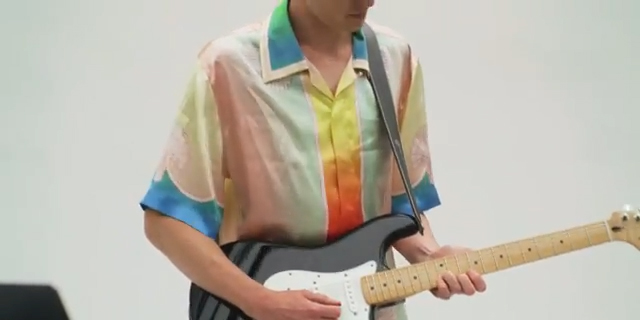

In [372]:
img1 = Image.open("images/LF016.jpg")
img2 = Image.open("images/LF017.jpg")
img1

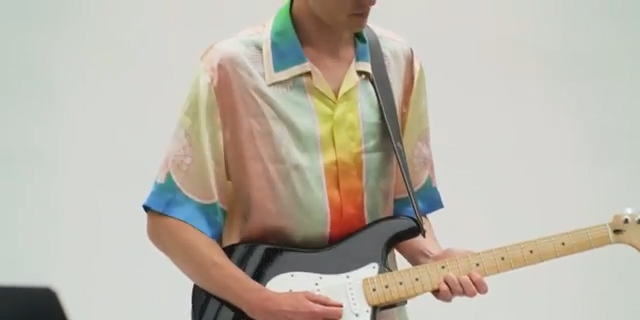

In [373]:
img2

## Création des nd arrays associés aux images

In [386]:
frame_array_1 = np.asarray(img1)
frame_array_2 = np.asarray(img2)
# Vérification 
assert frame_array_1.shape == frame_array_2.shape

# (A) Méthode pixel-wise

## Fonction qui mesure l'écart entre 2 pixels

In [367]:
def get_absolute_diff_sum(pixel_a, pixel_b):
    return (abs((pixel_a).astype(int) - (pixel_b).astype(int))).sum()

## Déterminer les vecteurs de mouvement

### Déterminer le vecteur au niveau d'un pixel

La fonction ci-dessous détermine le pixel de la frame 2 dont l'écart est le plus court avec le pixel x,y de la frame 1:

In [376]:
def get_closer_pixel(frame_array_1,frame_array_2,x,y, step):
    x_left_bound = max(0,x-step)
    x_right_bound = min(frame_array_1.shape[0],x+step+1)
    y_bottom_bound,y_top_bound =max(0,y-step),min(frame_array_1.shape[1],y+step+1)
    best_pixel_coord = None
    best_pixel = None
    pixel_to_find = frame_array_1[x][y]
    for i in range(step,-1,-1):
        for x_neigbour in range(x_left_bound,x_right_bound):
            for y_neigbour in range(y_bottom_bound,y_top_bound):
                if((abs(x_neigbour-x) + abs(y_neigbour-y)) == i):
                    neigbour_pixel = frame_array_2[x_neigbour][y_neigbour]
                    pixel_diff_sum = get_absolute_diff_sum(neigbour_pixel, pixel_to_find)
                    need_to_change = (best_pixel_coord is None)
                    need_to_change = need_to_change or (pixel_diff_sum <= get_absolute_diff_sum(best_pixel, pixel_to_find))
                    
                    if(need_to_change):
                        best_pixel_coord = x_neigbour,y_neigbour
                        best_pixel = neigbour_pixel
        
    return best_pixel_coord
    

Après avoir déterminer le pixel de la frame 2 le plus proche de celui de la frame 1 on renvoie un tuple qui correspond à un vecteur de mouvement.

In [377]:
def get_move_vector(frame_array_1,frame_array_2,x,y,step):
    new_x, new_y = get_closer_pixel(frame_array_1,frame_array_2,x,y,step)
    return new_x-x, new_y-y

### Déterminer les vecteurs de mouvement au niveau de tous les pixels de la frame

Le but va être de générer deux ndarrays u et v. Ces deux arrays correspondent respectivement aux coordonées directionnelles de chaque point de la frame.
u va représenter les abcisses de chaque point et v les ordonnées. 

In [399]:
def generate_move_vectors(frame_array_1,frame_array_2,step):
    count =0
    u = np.ndarray(shape=frame_array_1.shape[0:2])
    u.fill(0.)
    v = np.ndarray(shape=frame_array_1.shape[0:2])
    v.fill(0.)
    total_count = frame_array_1.shape[0]*frame_array_1.shape[1]
    first = time.time()
    for x in range(frame_array_1.shape[0]):
        for y in range(frame_array_1.shape[1]):
            if(count == total_count//100):
                second = time.time()
                estimated_time = (second -first)*100
                print(f'{int(estimated_time)//60} minutes and {int(estimated_time)%60} seconds left ')
            vector= get_move_vector(frame_array_1,frame_array_2,x,y,step)
            u[x][y]= vector[0]
            v[x][y]= vector[1]
            count+=1
    return u,v


## Afficher les vecteurs de mouvement

Il faut maintenant afficher via Quiver l'ensemble des vecteurs de mouvements

0 minutes and 29 seconds left 


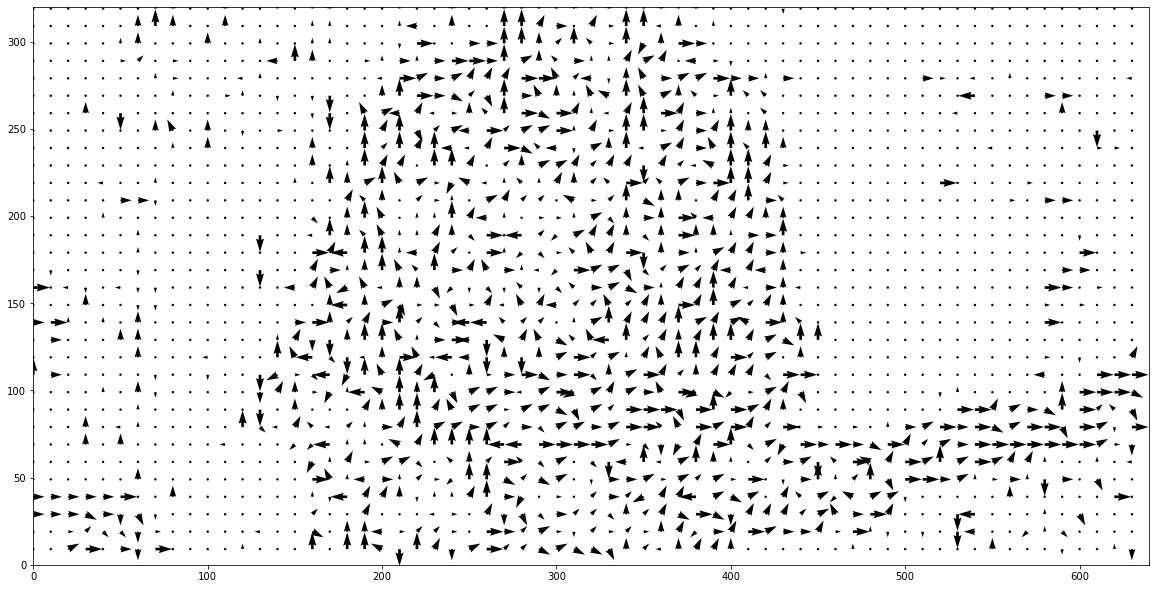

In [463]:
STEP = 3
INTERVAL = 10
def display_movement_vectors(frame_array_1,frame_array_2):
    
    u,v = generate_move_vectors(frame_array_1,frame_array_2,STEP)
    u =  u[::INTERVAL,::INTERVAL]
    v = v[::INTERVAL,::INTERVAL]
    x =  np.arange(frame_array_1.shape[1])  
    y = np.arange(frame_array_1.shape[0]-1,-1,-1) 
    X, Y = np.meshgrid(x[::INTERVAL], y[::INTERVAL])
    X.shape, Y.shape,u.shape, v.shape
    fig, ax = plt.subplots(figsize =(20, 20))
    ax.quiver(X, Y, u, v,scale=200)
    ax.axis([0, frame_array_1.shape[1], 0,frame_array_1.shape[0] ])
    ax.set_aspect('equal')
    plt.show()

display_movement_vectors(frame_array_1,frame_array_2)


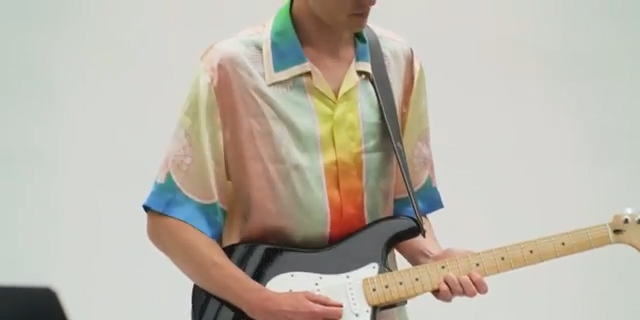

In [380]:
img2

# (B) Méthode par bloc

In [ ]:
#TODO